In [35]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score

In [36]:
#Model that will be assessed on

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
       n_estimators=1000,
       max_depth=7,
       n_jobs=-1,
       random_state=42)


In [37]:
#Load submission.csv data given as orig (original)
orig = pd.read_csv('/kaggle/input/playground-series-s3e21/sample_submission.csv')

orig.info()

orig_y = orig['target']
orig_X = orig.drop(columns = ['target'],
                  inplace = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 37 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      3500 non-null   int64  
 1   target  3500 non-null   float64
 2   O2_1    3500 non-null   float64
 3   O2_2    3500 non-null   float64
 4   O2_3    3500 non-null   float64
 5   O2_4    3500 non-null   float64
 6   O2_5    3500 non-null   float64
 7   O2_6    3500 non-null   float64
 8   O2_7    3500 non-null   float64
 9   NH4_1   3500 non-null   float64
 10  NH4_2   3500 non-null   float64
 11  NH4_3   3500 non-null   float64
 12  NH4_4   3500 non-null   float64
 13  NH4_5   3500 non-null   float64
 14  NH4_6   3500 non-null   float64
 15  NH4_7   3500 non-null   float64
 16  NO2_1   3500 non-null   float64
 17  NO2_2   3500 non-null   float64
 18  NO2_3   3500 non-null   float64
 19  NO2_4   3500 non-null   float64
 20  NO2_5   3500 non-null   float64
 21  NO2_6   3500 non-null   float64
 22  

**Original dataset - Univariate Linear correlations**

In [38]:
#Measuring correlation
orig_spearman = orig.corr(method = 'spearman')
orig_kendall = orig.corr(method = 'kendall')
orig_pearson = orig.corr(method = 'pearson')

spearman_best_df = pd.DataFrame(orig_spearman['target']).sort_values(by = 'target', ascending = False)
kendall_best_df = pd.DataFrame(orig_kendall['target']).sort_values(by = 'target', ascending = False)
pearson_best_df = pd.DataFrame(orig_pearson['target']).sort_values(by = 'target', ascending = False)

**Function to Select values within a 0.02 - 0.98 IPR or other values can use function, replace those outside with NULL**


In [39]:
def select_and_replace(lower_pct, upper_pct, columns, data):
    
    for column in columns:
        lower_pct_value = float(data[column].quantile(lower_pct))
        upper_pct_value = float(data[column].quantile(upper_pct))
        
        # Use boolean indexing to replace values outside the specified range with NaN
        data.loc[data[column] < lower_pct_value, column] = np.nan
        data.loc[data[column] > upper_pct_value, column] = np.nan
    
    # Remove rows with NaN values
    no_extreme_data = data.dropna(axis=0)
    return no_extreme_data

***Function to create features and target from processed dataset***

In [40]:
def create_features_target(processed_data):
    
    X = processed_data.drop(columns = ['target'],
                  inplace = False)
    y = processed_data['target']
    
    return X, y

**Find extreme data and remove**

In [41]:
#This is to check which columns need filtering down. Normally do not run. 

def plot_data_extremes(data):
    for column in data.columns:
        plt.figure(figsize = (8,8))
        sns.boxplot(data = orig,
                   x = orig[column])
        plt.title(f'{column} boxplot')

    
#NOTES#:

#Target - 2 extreme highs
#O2_2 - 4 extreme highs
#O2_3 - both ends
#O2_4 - extreme high
#O2_5 - extreme high
#O2_6 - both ends
#O2_7 - both ends
#NH4_1', 'NH4_2', 'NH4_3', 'NH4_4', 'NH4_5', 'NH4_6', 'NH4_7', 'NO2_1', 'NO2_2', 'NO2_3' - extreme highs
#NO2_4 - extreme low
#'NO2_5', 'NO2_6', 'NO2_7', 'NO3_1', 'NO3_2','NO3_3' - extreme highs
# up to NO3_7 - Exteme highs
# BOD5_1, BOD5_2 - both#
# 'BOD5_3', 'BOD5_4', 'BOD5_5', 'BOD5_6', 'BOD5_7' - extreme highs



In [42]:
removed_highs = select_and_replace(0, 0.99, ['O2_2', 'O2_4', 'O2_5', 'NH4_1', 'NH4_2', 'NH4_3', 'NH4_4', 'NH4_5', 'NH4_6', 'NH4_7', 'NO2_1', 'NO2_2', 'NO2_3',
                                            'NO2_5', 'NO2_6', 'NO2_7', 'NO3_1', 'NO3_2','NO3_3', 'NO3_4', 'NO3_5', 'NO3_6', 'NO3_7', 
                                            'BOD5_3', 'BOD5_4', 'BOD5_5', 'BOD5_6', 'BOD5_7'], orig)


removed_both = select_and_replace(0.01, 0.99, ['O2_3', 'O2_6', 'O2_7', 'BOD5_1', 'BOD5_2'], removed_highs)

removed_lows = select_and_replace(0.03, 1, ['NO2_4'], removed_both)


removed_lows.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 2656 entries, 0 to 3499
Data columns (total 37 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      2656 non-null   int64  
 1   target  2656 non-null   float64
 2   O2_1    2656 non-null   float64
 3   O2_2    2656 non-null   float64
 4   O2_3    2656 non-null   float64
 5   O2_4    2656 non-null   float64
 6   O2_5    2656 non-null   float64
 7   O2_6    2656 non-null   float64
 8   O2_7    2656 non-null   float64
 9   NH4_1   2656 non-null   float64
 10  NH4_2   2656 non-null   float64
 11  NH4_3   2656 non-null   float64
 12  NH4_4   2656 non-null   float64
 13  NH4_5   2656 non-null   float64
 14  NH4_6   2656 non-null   float64
 15  NH4_7   2656 non-null   float64
 16  NO2_1   2656 non-null   float64
 17  NO2_2   2656 non-null   float64
 18  NO2_3   2656 non-null   float64
 19  NO2_4   2656 non-null   float64
 20  NO2_5   2656 non-null   float64
 21  NO2_6   2656 non-null   float64
 22  

In [43]:
removed_lowsX, removed_lowsy = create_features_target(removed_lows)

In [44]:
print(cross_val_score(rf, removed_lowsX, removed_lowsy, cv = 5, scoring = 'neg_root_mean_squared_error'))
rf.fit(removed_lowsX, removed_lowsy)

[-1.72707883 -1.01967898 -1.13825006 -1.05043081 -0.96097208]


RandomForestRegressor(max_depth=7, n_estimators=1000, n_jobs=-1,
                      random_state=42)

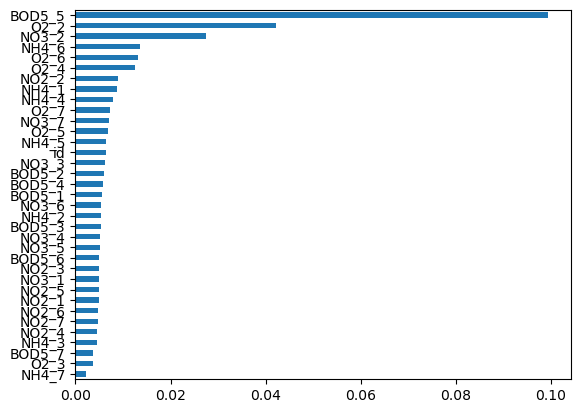

In [45]:
feat_importances = pd.Series(rf.feature_importances_, index=removed_lowsX.columns)
feat_importances.nsmallest(35).plot(kind='barh')

#From the plot, NH4_7 and O2_3 are noticeably less useful, so will set their values at 0

#From least to increasing usefulness
removed_lows['NH4_7'].value = 0

#removed_lows['O2_3'].value = 0
#removed_lows['NO2_4'].value = 0

**Transforming columns to see if this helps**


In [46]:
#plot_data_extremes(removed_lows)

#print(removed_lows['NH4_7'])
#Cols to log transform (badly skewed still): NH4_7, NO2_1, NO2_2, 
#removed_lows['NO2_1'] = np.log(removed_lows['NO2_1']).copy()


#Remove ~-4 value from NO2_4
#index_m4_no2_4 = removed_lows[removed_lows['NO2_4'] < 0].index
#print()
#print(index_m4_no2_4)

#removed_lows.drop(index_m4_no2_4, inplace = True)


**Submission**


In [47]:
#Error metric is RMSE
def create_submission(dataset):
    
    submitted_dataset = dataset.to_csv('submission.csv', index = False)

In [48]:
create_submission(removed_lows) # - Change and unhash when ready to submit! 